In [ ]:
---
title: "Introduction to Quantum Singular Value Transformation"
description: "Or grand unification of quantum algorithms, if you feel a bit grandiose."
aliases:
  - quantum_singular_value_transformation_intro.html
bibliography: references.bib
csl: physical-review-letters.csl
toc: true
image: what_to_use_qc_for.svg
date: '2023-05-15'

format:
  html:
    html-math-method: mathjax
    include-in-header:
      - text: |
          <script>
          window.MathJax = {
            tex: {
              tags: 'ams'
            }
          };
          </script>
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

# Quantum signal processing

Define the basic setup of quantum signal processing.
- Implementing arbitrary polynomials subject to conditions.
- Measure in $|\pm\rangle$ basis.
- Automated way to find phases.

In [41]:
def Wx(a):

#     b = 1j*np.sqrt(1-a**2)
#     W = np.array([
#         [a, b],
#         [b, a]])

    b = np.sqrt(1-a**2)
    W = np.array([
        [a, b],
        [b, -a]])

    return W

def Sz(phi):
    return np.diag([np.exp(1j*phi), np.exp(-1j*phi)])

def apply_QSP(w, phis):
    
    assert len(phis)>0, 'At least one angle must be provided.'
    phis = \
    [phis[0]+(2*len(phis)-3)*np.pi/4] \
    + [phi-np.pi/2 for phi in phis[1:-1]] \
    + [phis[-1]-np.pi/4]
    
    
    # Need to apply S(phi_0) @ w @ s(phi_1) @ w ... @ S(phi_d-1) @ w @ S(phi_d).
    
    res = Sz(phis[-1])
    w_dagger = w.conj().T
    dagger = False
    for phi in phis[:-1][::-1]:
        if dagger:
            w0 = w_dagger
        else:
            w0 = w
        dagger = not dagger
        
        res = Sz(phi) @ w0 @ res
    
    return res

Exercise: implement polynomial by phases.

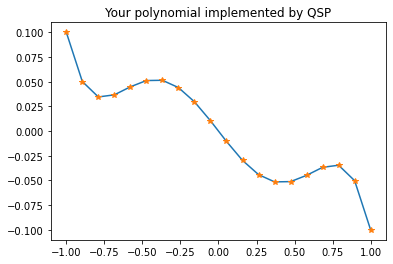

In [42]:
# An excersize.

def polynomial_value(coeffs, x):
    """ Computes c[0]*x**0 + c[1]*x**1+...+c[n]*x**n. """
    x = np.array([x])
    return (np.array(coeffs) * x**np.arange(len(coeffs))).sum()

# Som arbitrary set of polynomial coefficiets.
# Must define even or odd polynomial p(x) that satisfies p(x)<1 for -1<x<1. 

coeffs =  [0., -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 20)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

# Compute matrix elements of the QSP sequence
unitaries = [apply_QSP(Wx(xi), phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

# QSVT

- Block embedding in the computational basis
$$U=\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}$$
- For a single-qubit embedding $U=|0\rangle \langle0|\otimes A+\dots$.
- More generally, there is some basis change $B_L, B_R$ that leads to the standard block-encoding
$$U=B_L\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}B_R$$
With any such basis we associated projectors $\Pi_L=B_L\left(|0\rangle\langle0|\otimes \mathbb{1} \right)B_L^\dagger $ which satisfy
$$\Pi_L U \Pi_R = B_L\begin{pmatrix}A&0\\0&0\end{pmatrix}B_R$$
- We need access to 
$$\Pi_L(\phi)=e^{(2\Pi_L-\mathbb{I})\phi}=B_L \begin{pmatrix}e^{i\phi}&0\\ 0&e^{-i\phi}\end{pmatrix}B_L^\dagger$$

Then, the main statement of QSVT is the following. A bit awkwardly, it needs to be split in two cases. First consider when the polynomial is even (the number of phases is odd)

$$U_{\phi}=\prod_{i=0}^{d/2-1}\Pi_R(\phi_{2i})U^\dagger\Pi_L(\phi_{2i+1})U$$
When the polynomial is odd (the number of phases even)

$$U_{\phi}=\Pi_L(\phi_{0})U\prod_{i=1}^{(d-1)/2}\Pi_R(\phi_{2i-1})U^\dagger\Pi_L(\phi_{2i})U$$

# Amplitude amplification

Encompasses
1. Grover's search.
1. Oblivious amplitude amplification.
1. Used in other quantum algorithms.

# Hamiltonian simulation

We are given three things

1. Block embedding of a Hamiltonian $H$, i.e. $U$ s.t. $H=\left(\langle 0|\otimes I \right)U\left(|0\rangle\otimes I\right)$.
2. Projectors $\Pi(\phi)$.
3. ??


## Block encodings

Singular value $\sigma$ are positive square roots of eigenvalues $M^\dagger M\ge0$.

To block encode some matrix $M$ we need $||M||\le1$ where $||\cdot||$ is the operator norm or, equivalently, the largest singular value.

In [1]:
import numpy as np

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

In [2]:
class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*max(self.num_rows, self.num_cols)
        
        self.diagonal_block = self.pad_matrix_to_square(M)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
                    
    @staticmethod
    def pad_matrix_to_square(M):
        """Pads a matrix with zeros to make it square."""

        n_rows, n_cols = M.shape
        n_max = max(n_rows, n_cols)
        S = np.zeros((n_max, n_max))
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n))
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n)), 'Ops, block encoding is not unitary.'
        return U

In [ ]:
def apply_QSVT(U, Phi, P_left, P_right):
    

In [14]:
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
ang_seq = QuantumSignalProcessingPhases([0.2, 0., 0.3], signal_operator="R")
print(ang_seq)

ValueError: Invalid model: ('R', None)

In [3]:
degree = 15
pyqsp.response.PlotQSPResponse(
    get_amplitude_amplification_angles(degree),
    target=lambda x: np.sign(x),
    signal_operator='Wx',
    title="Sign Function")

NameError: name 'get_amplitude_amplification_angles' is not defined